# BE 521: Final Project Part 1
Team Member: Sanghyub(Paul) Lee, Beichen Zhai, Yanjun Zhou


## Load data

In [1]:
#Set up the notebook environment
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.io
from scipy.stats import pearsonr
from scipy import signal as sig
from keras.models import load_model
from scipy.io import loadmat, savemat
from sklearn.preprocessing import RobustScaler
import os

In [2]:
import numpy as np
import random
import tensorflow as tf

# Set random seeds to make the experiments reproducible
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Load the data from the pickle file
file_path = '/content/drive/My Drive/raw_training_data.mat'
proj_data = scipy.io.loadmat(file_path)

file_path_ = '/content//drive/My Drive/leaderboard_data.mat'
test_data = scipy.io.loadmat(file_path_)

In [5]:
leaderboard_ecog = test_data['leaderboard_ecog']

for i, array in enumerate(leaderboard_ecog[0]):
    print(f"Shape of array {i+1}: {array.shape}")

Shape of array 1: (147500, 62)


In [6]:
train_ecog = proj_data['train_ecog']

for i, array in enumerate(train_ecog[0]):
    print(f"Shape of array {i+1}: {array.shape}")

Shape of array 1: (300000, 62)


In [7]:
train_dg= proj_data['train_dg']

for i, array in enumerate(train_dg[0]):
    print(f"Shape of array {i+1}: {array.shape}")

Shape of array 1: (300000, 5)


## Prepocess dataset

In [8]:
from scipy.signal import butter, filtfilt, iirnotch
import numpy as np

def preprocess_ecog(data):
    # Standardize data
    median = np.median(data, axis=0)
    std = np.std(data, axis=0)
    standardized_data = (data - median) / std

    return standardized_data

In [9]:
# Function to preprocess each subject's data
def preprocess_all_subjects(data):
    preprocessed_data = []
    for subject_array in data:
        subject_data = subject_array[0]  # Access the nested array
        preprocessed_subject_data = preprocess_ecog(subject_data)
        preprocessed_data.append(preprocessed_subject_data)
    return preprocessed_data  # Return as list

# Apply preprocessing
preprocessed_train_ecog = preprocess_all_subjects(train_ecog)
preprocessed_leaderboard_ecog = preprocess_all_subjects(leaderboard_ecog)

In [10]:
print("Preprocessed Train ECoG Shape:", [data.shape for data in preprocessed_train_ecog])
print("Preprocessed Test ECoG Shape:", [data.shape for data in preprocessed_leaderboard_ecog])

Preprocessed Train ECoG Shape: [(300000, 62), (300000, 48), (300000, 64)]
Preprocessed Test ECoG Shape: [(147500, 62), (147500, 48), (147500, 64)]


## Define Bandpass and Notch Filters


In [11]:
from scipy.signal import butter, lfilter, iirnotch, filtfilt
import numpy as np

def bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y

def notch_filter(data, frequency, fs, quality_factor):
    nyq = 0.5 * fs
    freq = frequency / nyq
    b, a = iirnotch(freq, quality_factor)
    y = filtfilt(b, a, data)
    return y

In [12]:
optimal_params = {'bandpass_range': (40, 300), 'notch_quality_factor': 50}

# Apply filters with optimal parameters to both datasets
def apply_optimal_filters(data_list, params):
    filtered_data_list = []
    for data in data_list:
        filtered_data = bandpass_filter(data, params['bandpass_range'][0], params['bandpass_range'][1], fs=1000)
        for freq in [50, 100, 150, 200, 250]:
            filtered_data = notch_filter(filtered_data, freq, fs=1000, quality_factor=params['notch_quality_factor'])
        filtered_data_list.append(filtered_data)
    return filtered_data_list

filtered_train_ecog = apply_optimal_filters(preprocessed_train_ecog, optimal_params)
filtered_leaderboard_ecog = apply_optimal_filters(preprocessed_leaderboard_ecog, optimal_params)

In [13]:
print("filtered Train ECoG Shape:", [data.shape for data in filtered_train_ecog])
print("filtered Test ECoG Shape:", [data.shape for data in filtered_leaderboard_ecog])

filtered Train ECoG Shape: [(300000, 62), (300000, 48), (300000, 64)]
filtered Test ECoG Shape: [(147500, 62), (147500, 48), (147500, 64)]


In [14]:
from scipy.signal import decimate, resample

def decimate_and_resample_column(column, desired_samples):
    original_samples = len(column)
    decimation_factor = np.ceil(original_samples / desired_samples).astype(int)
    if decimation_factor > 1:
        column_decimated = decimate(column, decimation_factor, ftype='fir')
    else:
        column_decimated = column
    column_resampled = resample(column_decimated, desired_samples)
    return column_resampled

def decimate_data_glove(data_glove, desired_samples):
    data_glove_resampled = np.zeros((desired_samples, data_glove.shape[1]))
    for i in range(data_glove.shape[1]):  # Process each finger's data separately
        column = data_glove[:, i]
        original_samples = len(column)
        decimation_factor = np.ceil(original_samples / desired_samples).astype(int)

        if decimation_factor > 1:
            column_decimated = decimate(column, decimation_factor, ftype='fir')
        else:
            column_decimated = column

        column_resampled = resample(column_decimated, desired_samples)
        data_glove_resampled[:, i] = column_resampled
    return data_glove_resampled

# Feature Extraction


In [15]:
from scipy.signal import welch, convolve
import pywt

def spectral_entropy(signal, fs, method='welch', nperseg=None):
    if nperseg is None or nperseg > len(signal):
        nperseg = len(signal)  # Adjust nperseg based on signal length
    freqs, psd = welch(signal, fs=fs, nperseg=nperseg)
    psd_norm = psd / np.sum(psd)
    entropy = -np.sum(psd_norm * np.log(psd_norm))
    return entropy

def get_wavelet_features(data, wavelet_name='db4', max_level=None):
    if max_level is None:
        max_level = pywt.dwt_max_level(len(data), pywt.Wavelet(wavelet_name).dec_len)
    coeffs = pywt.wavedec(data, wavelet_name, level=max_level)
    features = []
    for coeff in coeffs:
        features.extend([np.mean(coeff), np.std(coeff)])
    return features
    return features

def get_band_power(pxx, freqs, freq_range):
    """Helper function to compute power in a specific frequency band."""
    band_mask = (freqs >= freq_range[0]) & (freqs <= freq_range[1])
    band_power = np.sum(pxx[band_mask])
    return band_power

def get_features(filtered_window, fs=1000):
    """
    Calculate specific features for a given filtered window:
    - Time-domain feature: average voltage
    - Frequency-domain features: average magnitude in five specified bands
    """
    d = len(filtered_window)
    lmp_kernel = np.ones(d) / d  # Create averaging kernel
    features = []
    # Iterate over channels
    for channel_data in filtered_window.T:
      # Time domain features
      mean_voltage = np.mean(channel_data)
      variance = np.var(channel_data)
      # Calculate LMP by applying the averaging kernel
      lmp = convolve(channel_data, lmp_kernel, mode='same')

      nperseg = min(256, len(channel_data))
      freqs, pxx = welch(channel_data, fs=fs, nperseg=nperseg)
      entropy_measure = spectral_entropy(channel_data, fs, nperseg=nperseg)

      # Frequency domain features using Welch's method
      freqs, pxx = welch(channel_data, fs=fs, nperseg=len(channel_data))
      delta_power = get_band_power(pxx, freqs, (5, 15))
      theta_power = get_band_power(pxx, freqs, (20, 25))
      alpha_power = get_band_power(pxx, freqs, (75, 115))
      beta_power = get_band_power(pxx, freqs, (125, 160))
      gamma_power = get_band_power(pxx, freqs, (160, 175))

      wavelet_features = get_wavelet_features(channel_data, max_level=pywt.dwt_max_level(len(channel_data), 'db4'))

      channel_features = [
          mean_voltage, variance, np.mean(lmp), entropy_measure,
          delta_power, theta_power, alpha_power, beta_power, gamma_power
          ] + wavelet_features
      features.append(channel_features)

    features_array = np.concatenate(features, axis=0)
    return features_array

In [16]:
def get_windowed_feats(filtered_data, fs=1000, window_length=0.1, window_overlap=0.05):
    # Calculate the number of samples per window and overlap
    window_length_samples = int(window_length * fs)
    window_overlap_samples = int(window_overlap * fs)

    # Calculate the step size
    step_size = window_length_samples - window_overlap_samples

    # Initialize the list to hold all features from all windows
    all_feats = []

    # Calculate features for each window
    for start in range(0, filtered_data.shape[0] - window_length_samples + 1, step_size):
        end = start + window_length_samples
        window = filtered_data[start:end, :]

        # Calculate features for the current window
        window_feats = get_features(window, fs)

        # Flatten the features and append to the list of all features
        all_feats.append(window_feats.flatten())

    return np.array(all_feats)

In [17]:
from sklearn.feature_selection import SelectKBest, f_regression

# Function to select features
def select_features(X, y, k=50):
    """
    Select the top 'k' features based on the highest F-values in regression.
    X - input feature matrix
    y - corresponding labels (should be 1D)
    k - number of top features to select
    """
    # Applying SelectKBest to extract top 'k' features using f_regression
    selector = SelectKBest(f_regression, k=k)
    X_new = selector.fit_transform(X, y)  # Ensure y is the correct shape
    return X_new, selector

## ML training

In [18]:
from sklearn.preprocessing import RobustScaler

def normalize_features(features_list):
    """ Normalize a list of feature arrays using RobustScaler independently for each list. """
    scaler = RobustScaler()
    normalized_features = [scaler.fit_transform(features) for features in features_list]
    return normalized_features

In [19]:
def create_X_matrix(features, N_wind):
    num_samples, total_features_per_window = features.shape
    X = np.ones((num_samples, 1 + N_wind * total_features_per_window))  # Plus one for the intercept term

    # To handle initial windows, prepend features from the first few windows
    prepended_features = np.vstack((features[:N_wind-1], features))

    for i in range(num_samples):
        window_features = prepended_features[i:i+N_wind].reshape(-1)
        X[i, 1:] = window_features  # Fill with concatenated features

    return X

In [20]:
num_fingers_per_subject = [5, 5, 5]  # Adjust this according to actual data

# Main processing loop for each subject
X_list, Y_list = [], []
selectors = [[] for _ in range(len(filtered_train_ecog))]  # Initialize selectors as a list of lists

for subject_idx in range(len(filtered_train_ecog)):
    features = get_windowed_feats(filtered_train_ecog[subject_idx])
    data_glove = train_dg[subject_idx][0]
    desired_samples = features.shape[0]
    Y = decimate_data_glove(data_glove, desired_samples)

    all_selected_features = []
    for finger_idx in range(Y.shape[1]):
        selected_features, selector = select_features(features, Y[:, finger_idx])
        all_selected_features.append(selected_features)
        selectors[subject_idx].append(selector)  # Store selector for each finger of each subject

    combined_features = np.concatenate(all_selected_features, axis=1)

    scaler = RobustScaler()
    normalized_features = scaler.fit_transform(combined_features)

    X = create_X_matrix(normalized_features, N_wind=30)
    print(f"Shape of X for Subject {subject_idx+1}: {X.shape}")
    print(f"Shape of Y after resampling to match X: {Y.shape}")

    X_list.append(X)
    Y_list.append(Y)

Shape of X for Subject 1: (5999, 7501)
Shape of Y after resampling to match X: (5999, 5)
Shape of X for Subject 2: (5999, 7501)
Shape of Y after resampling to match X: (5999, 5)
Shape of X for Subject 3: (5999, 7501)
Shape of Y after resampling to match X: (5999, 5)


In [21]:
# Calculate correlation for each finger
def calculate_finger_correlations(Y_true, Y_pred):
    return [pearsonr(Y_true[:, i], Y_pred[:, i])[0] for i in range(5)]  # 5 fingers

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
# Split the data and scale it
X_train_list, X_test_list, Y_train_list, Y_test_list = [], [], [], []
Y_scalers = []

for subject_idx in range(3):
    # Split data
    X_train, X_test, Y_train, Y_test = train_test_split(
        X_list[subject_idx], Y_list[subject_idx], test_size=0.3, random_state=42
    )

    Y_scaler = RobustScaler()
    Y_train_scaled = Y_scaler.fit_transform(Y_train)
    Y_test_scaled = Y_scaler.transform(Y_test)

    # Append scaled and split data to the lists
    X_train_list.append(X_train)
    X_test_list.append(X_test)
    Y_train_list.append(Y_train_scaled)
    Y_test_list.append(Y_test_scaled)

    Y_scalers.append(Y_scaler) # Save scalers for inverse transformation later

In [23]:
for idx in range(3):
  print("Training features shape:", X_train_list[idx].shape)

Training features shape: (4199, 7501)
Training features shape: (4199, 7501)
Training features shape: (4199, 7501)


In [24]:
pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.3 MB/s eta 0:00:00


In [25]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
import numpy as np
import keras_tuner as kt

models = []
correlations_list = []

def build_model(hp, input_dim):
    model = Sequential([
        Dense(units=hp.Int('units1', min_value=64, max_value=256, step=32), activation='relu', input_dim=input_dim),
        Dropout(rate=hp.Float('dropout1', min_value=0.1, max_value=0.5, step=0.1)),
        Dense(units=hp.Int('units2', min_value=64, max_value=256, step=32), activation='relu'),
        Dense(Y_train_list[0].shape[1])  # Assuming output dimensions are consistent across subjects
    ])
    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])), loss='mean_squared_error')
    return model

for subject_idx in range(3):
    tuner = kt.RandomSearch(
        lambda hp: build_model(hp, X_train_list[subject_idx].shape[1]),
        objective='val_loss',
        max_trials=5,
        executions_per_trial=1,
        directory='my_dir',
        project_name=f'keras_tuning_{subject_idx}'
    )

    tuner.search(X_train_list[subject_idx], Y_train_list[subject_idx], epochs=50, validation_split=0.2, verbose=0)

    best_model = tuner.get_best_models(num_models=1)[0]
    best_hp = tuner.get_best_hyperparameters()[0].values

    # Predict on the test set
    Y_pred_scaled = best_model.predict(X_test_list[subject_idx])
    Y_pred = Y_scalers[subject_idx].inverse_transform(Y_pred_scaled)  # Inverse scaling of predictions using Y_scaler

    # Calculate MSE and correlations on the original scale
    mse = mean_squared_error(Y_test_list[subject_idx], Y_pred)
    correlations = [pearsonr(Y_test_list[subject_idx][:, i], Y_pred[:, i])[0] for i in range(Y_pred.shape[1])]

    print(f"Dense Network MSE for Subject {subject_idx + 1}: {mse}")
    print(f"Subject {subject_idx+1} Dense Network Correlations:", correlations)
    print(f"Best hyperparameters for Subject {subject_idx + 1}: {best_hp}")

    models.append(best_model)
    correlations_list.append(correlations)

# Calculate the mean of all correlations
mean_correlation = np.mean([np.mean(corr) for corr in correlations_list])
print(f"Mean of all Dense Network Correlations: {mean_correlation}")

57/57 [==============================] - 0s 3ms/step
Dense Network MSE for Subject 1: 5.899250299320516
Subject 1 Dense Network Correlations: [0.7944117463208087, 0.8359668639590356, 0.7674947338697821, 0.7678780240380059, 0.8115266991366404]
Best hyperparameters for Subject 1: {'units1': 192, 'dropout1': 0.1, 'units2': 128, 'learning_rate': 0.001}
57/57 [==============================] - 0s 3ms/step
Dense Network MSE for Subject 2: 2.7195272163763264
Subject 2 Dense Network Correlations: [0.8739543958888423, 0.7247229720128481, 0.7140515800926451, 0.6975303929010223, 0.7162158989763885]
Best hyperparameters for Subject 2: {'units1': 224, 'dropout1': 0.1, 'units2': 160, 'learning_rate': 0.001}
57/57 [==============================] - 0s 4ms/step
Dense Network MSE for Subject 3: 2.900910868778719
Subject 3 Dense Network Correlations: [0.9367529189186554, 0.8647805040289575, 0.8919698436298094, 0.9171454619931448, 0.9143036586626889]
Best hyperparameters for Subject 3: {'units1': 224, 'd

### Test data

In [26]:
leaderboard_features_subjects = []
X_list_leader = []

for subject_idx in range(len(filtered_leaderboard_ecog)):
    print(f"\nProcessing Leaderboard Subject {subject_idx+1}")
    features = get_windowed_feats(filtered_leaderboard_ecog[subject_idx])

    all_selected_features = []
    for finger_idx in range(len(selectors[subject_idx])):
        selector = selectors[subject_idx][finger_idx]
        if selector is None:
            raise ValueError(f"No selector found for subject {subject_idx}, finger {finger_idx}")
        selected_features = selector.transform(features)
        all_selected_features.append(selected_features)

    combined_features = np.concatenate(all_selected_features, axis=1)
    print(f"Number of features combined for Subject {subject_idx+1}: {combined_features.shape[1]}")

    scaler = RobustScaler()
    normalized_features = scaler.fit_transform(combined_features)

    X_leader = create_X_matrix(normalized_features, N_wind=30)
    print(f"Shape of X(leader) for Subject {subject_idx+1}: {X_leader.shape}")

    X_list_leader.append(X_leader)


Processing Leaderboard Subject 1
Number of features combined for Subject 1: 250
Shape of X(leader) for Subject 1: (2949, 7501)

Processing Leaderboard Subject 2
Number of features combined for Subject 2: 250
Shape of X(leader) for Subject 2: (2949, 7501)

Processing Leaderboard Subject 3
Number of features combined for Subject 3: 250
Shape of X(leader) for Subject 3: (2949, 7501)


In [27]:
predicted_dg = []

for subject_idx, X_leader in enumerate(X_list_leader):
    # Ensure we're using the correct model for the subject
    current_model = models[subject_idx]

    # Predict the glove data for the current subject
    Y_leader_pred_scaled = current_model.predict(X_leader)

    # If scaling was applied to the Y data during training, invert it for the predictions
    Y_leader_pred = Y_scalers[subject_idx].inverse_transform(Y_leader_pred_scaled)

    # Append the predicted data glove values to the list
    predicted_dg.append(Y_leader_pred)

    # Optionally print some output to understand the shapes and first few values
    print(f"Predictions for Subject {subject_idx + 1}: {Y_leader_pred.shape}")

93/93 [==============================] - 0s 3ms/step
Predictions for Subject 1: (2949, 5)
93/93 [==============================] - 0s 4ms/step
Predictions for Subject 2: (2949, 5)
93/93 [==============================] - 0s 4ms/step
Predictions for Subject 3: (2949, 5)


In [28]:
from scipy.interpolate import CubicSpline
import numpy as np

def safe_cubic_spline_interpolation(predictions, num_samples):
    # Ensure interpolation only happens within the original data bounds
    x_old = np.linspace(0, predictions.shape[0] - 1, num=predictions.shape[0])
    x_new = np.linspace(0, predictions.shape[0] - 1, num=num_samples)
    interpolated_predictions = np.zeros((num_samples, predictions.shape[1]))

    # Handling boundary conditions explicitly
    for i in range(predictions.shape[1]):
        cs = CubicSpline(x_old, predictions[:, i], bc_type='not-a-knot')
        # Apply interpolation within bounds and extrapolate with zeros beyond the known range
        interpolated_predictions[:, i] = cs(x_new, extrapolate=False)

    return interpolated_predictions

In [29]:
def pad_predictions(interpolated_predictions, num_samples):
    # Pad with zeros if necessary to match the exact sample count
    if interpolated_predictions.shape[0] < num_samples:
        pad_length = num_samples - interpolated_predictions.shape[0]
        pad_start = pad_length // 2
        pad_end = pad_length - pad_start
        padded_predictions = np.pad(interpolated_predictions, ((pad_start, pad_end), (0, 0)), 'constant', constant_values=(0, 0))
        return padded_predictions
    return interpolated_predictions

# Interpolating and padding the predictions
predicted_dg_full_1 = [pad_predictions(safe_cubic_spline_interpolation(pred, 147500), 147500) for pred in predicted_dg]

# Checking the final shapes and contents
for idx, pred in enumerate(predicted_dg_full_1):
    print(f"Processed predictions shape for Subject {idx+1}: {pred.shape}")
    # Check for any remaining NaNs
    if np.isnan(pred).any():
        print(f"NaN values found in predictions for Subject {idx+1}")
    else:
        print(f"No NaN values in predictions for Subject {idx+1}")

Processed predictions shape for Subject 1: (147500, 5)
No NaN values in predictions for Subject 1
Processed predictions shape for Subject 2: (147500, 5)
No NaN values in predictions for Subject 2
Processed predictions shape for Subject 3: (147500, 5)
No NaN values in predictions for Subject 3


In [37]:

from scipy.signal import savgol_filter

def apply_savgol_filter(predictions, window_length=300, polyorder=3):
    # Ensure the window length is less than the number of data points and odd
    if window_length > predictions.shape[0]:
        window_length = predictions.shape[0] // 2 * 2 + 1  # make it odd
    smoothed_predictions = np.zeros_like(predictions)
    for i in range(predictions.shape[1]):  # Apply filter to each finger separately
        smoothed_predictions[:, i] = savgol_filter(predictions[:, i], window_length, polyorder)

    return smoothed_predictions

# Applying the Savitzky-Golay filter to your interpolated predictions
predicted_dg_smoothed = [apply_savgol_filter(pred) for pred in predicted_dg_full_1]

# Check and compare the smoothed predictions
for idx, pred in enumerate(predicted_dg_smoothed):
    print(f"Smoothed predictions shape for Subject {idx+1}: {pred.shape}")

Smoothed predictions shape for Subject 1: (147500, 5)
Smoothed predictions shape for Subject 2: (147500, 5)
Smoothed predictions shape for Subject 3: (147500, 5)


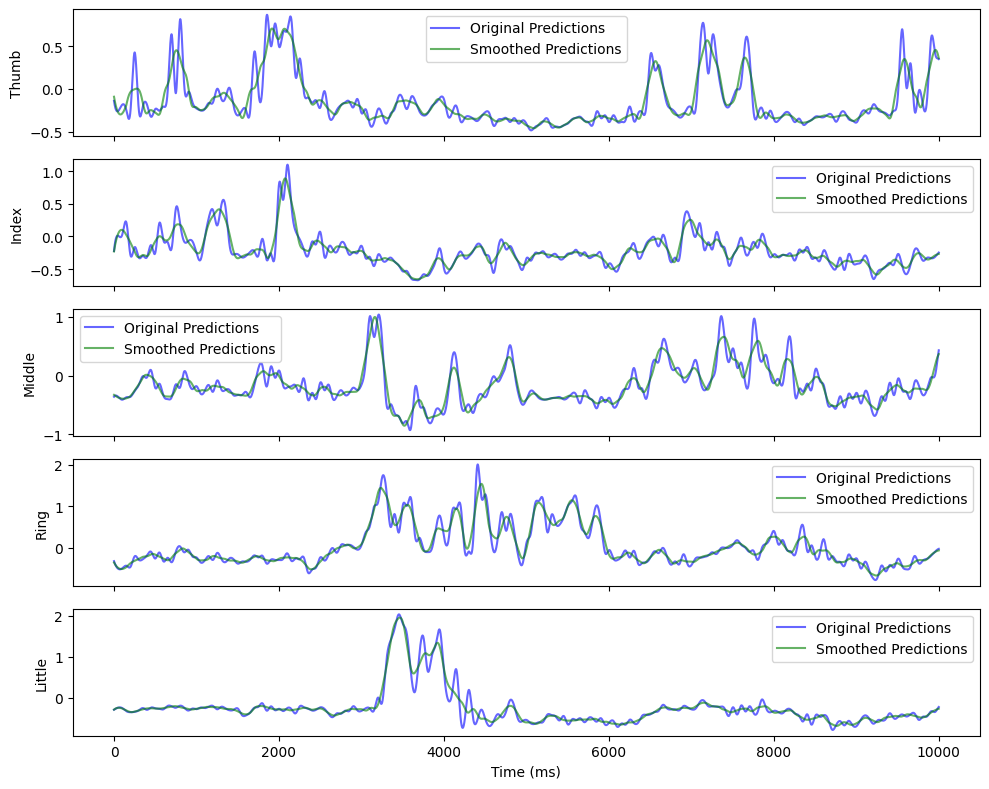

In [41]:
num_fingers = 5

# Define the names of the fingers for labeling
finger_names = ['Thumb', 'Index', 'Middle', 'Ring', 'Little']

# Create a plot with subplots for each finger
zoom_samples = 10000

# Create a plot with subplots for each finger
fig, axs = plt.subplots(num_fingers, 1, figsize=(10, 8), sharex=True)

for i in range(num_fingers):
    # Assuming the sampling rate is such that 100 samples correspond to 100 ms
    axs[i].plot(predicted_dg_full_1[0][:zoom_samples, i], label='Original Predictions', color='blue', alpha=0.6)
    axs[i].plot(predicted_dg_smoothed[0][:zoom_samples, i], label='Smoothed Predictions', color='green', alpha=0.6)
    axs[i].set_ylabel(f'{finger_names[i]}')
    axs[i].legend()
# Set common labels
axs[-1].set_xlabel('Time (ms)')
plt.tight_layout()
plt.show()

In [40]:
from scipy.io import savemat

# Save the predictions in MATLAB compatible format
predictions = np.zeros((3, 1), dtype=object)  # Create a (3, 1) object array to store data as required

for i in range(3):  # Assuming you have three subjects
    predictions[i, 0] = predicted_dg_smoothed[i]  # Assign each subject's predictions to the object array

# Specify the path and file name for saving the predictions in MATLAB compatible format
file_path_matlab = '/content/predicted_dg.mat'

# Save the structured predictions to a .mat file
savemat(file_path_matlab, {'predicted_dg': predictions})
print(f"Predictions saved in the required format to '{file_path_matlab}'.")

Predictions saved in the required format to '/content/predicted_dg.mat'.


In [33]:
predicted_dg_full_1

[array([[-0.14035469, -0.22321224, -0.35903317, -0.32574961, -0.29277629],
        [-0.1470526 , -0.2105128 , -0.3570381 , -0.3318632 , -0.29151163],
        [-0.15352647, -0.19825842, -0.35515507, -0.33786626, -0.29025064],
        ...,
        [-0.41672553, -0.03166002,  0.2418505 ,  0.96051941,  0.14273131],
        [-0.41787626, -0.03874269,  0.22641336,  0.96688968,  0.12887683],
        [-0.41906726, -0.04613512,  0.21021134,  0.97330719,  0.11450053]]),
 array([[-0.38286382, -0.40921342, -0.15467873, -0.23641407, -0.11778942],
        [-0.38401851, -0.4087305 , -0.15380272, -0.23081706, -0.12347706],
        [-0.38511026, -0.40820737, -0.15295926, -0.22535641, -0.12881965],
        ...,
        [-0.54328742, -0.03650502,  1.87002751,  0.28721956, -0.38857661],
        [-0.54867374, -0.06879954,  1.92921735,  0.29244987, -0.3972789 ],
        [-0.55400562, -0.10260117,  1.99034524,  0.29781991, -0.40653926]]),
 array([[-0.232006  , -0.33575124, -0.17672458, -0.11519341, -0.424684

In [39]:
predicted_dg_smoothed

[array([[-0.0920576 , -0.22975459, -0.32648601, -0.35834077, -0.29061397],
        [-0.09783178, -0.22172875, -0.32757474, -0.36214541, -0.28885241],
        [-0.10351257, -0.21381895, -0.32865578, -0.36589672, -0.28713006],
        ...,
        [-0.38869896,  0.06881599,  0.53999455,  0.67725717,  0.25451948],
        [-0.38763395,  0.07059014,  0.5508114 ,  0.66936222,  0.2506642 ],
        [-0.38655143,  0.07235243,  0.56172819,  0.66133117,  0.24663022]]),
 array([[-0.42921595, -0.39841068, -0.14153706, -0.13989032, -0.14035943],
        [-0.42710435, -0.39722402, -0.14145247, -0.13927047, -0.13996888],
        [-0.42503137, -0.39606717, -0.14138048, -0.13870482, -0.13956571],
        ...,
        [-0.68499441,  0.25320069,  1.29956021,  0.51217972, -0.347042  ],
        [-0.70066382,  0.256906  ,  1.30212462,  0.52880734, -0.34441577],
        [-0.71655373,  0.2606086 ,  1.30454556,  0.54572299, -0.34174712]]),
 array([[-0.2603858 , -0.34672636, -0.18052659, -0.14941036, -0.429145

In [35]:
import pickle
from keras.models import load_model

# Saving the models and preprocessing tools
for idx in range(len(models)):
    models[idx].save(f'model_subject_{idx}.h5')  # Save Keras model
    with open(f'selector_subject_{idx}.pkl', 'wb') as file:
        pickle.dump(selectors[idx], file)  # Save selectors for each finger
    with open(f'scaler_subject_{idx}.pkl', 'wb') as file:
        pickle.dump(Y_scalers[idx], file)  # Save Y_scaler used for inverse transformation

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [36]:
import shutil
import os

# Creating a directory for all files
os.makedirs('submission_files', exist_ok=True)
shutil.move('model_subject_0.h5', 'submission_files/model_subject_0.h5')
shutil.move('selector_subject_0.pkl', 'submission_files/selector_subject_0.pkl')
shutil.move('scaler_subject_0.pkl', 'submission_files/scaler_subject_0.pkl')
shutil.move('model_subject_1.h5', 'submission_files/model_subject_1.h5')
shutil.move('selector_subject_1.pkl', 'submission_files/selector_subject_1.pkl')
shutil.move('scaler_subject_1.pkl', 'submission_files/scaler_subject_1.pkl')
shutil.move('model_subject_2.h5', 'submission_files/model_subject_2.h5')
shutil.move('selector_subject_2.pkl', 'submission_files/selector_subject_2.pkl')
shutil.move('scaler_subject_2.pkl', 'submission_files/scaler_subject_2.pkl')

# Creating a zip file
shutil.make_archive('final_submission', 'zip', 'submission_files')

'/content/final_submission.zip'